In [1]:
import tensorflow as tf

for gpu in tf.config.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(gpu, True)

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Other imports for processing data
import string
import numpy as np
import pandas as pd

In [2]:
def tokenize_corpus(corpus, num_words=-1):
    # Fit a Tokenizer on the corpus
    if num_words > -1:
        tokenizer = Tokenizer(num_words=num_words)
    else:
        tokenizer = Tokenizer()
    tokenizer.fit_on_texts(corpus)
    return tokenizer

def create_lyrics_corpus(dataset, field):
    # Remove all other punctuation
    dataset[field] = dataset[field].str.replace('[{}]'.format(string.punctuation), '')
    # Make it lowercase
    dataset[field] = dataset[field].str.lower()
    # Make it one long string to split by line
    lyrics = dataset[field].str.cat()
    corpus = lyrics.split('\n')
    # Remove any trailing whitespace
    for l in range(len(corpus)):
        corpus[l] = corpus[l].rstrip()
    # Remove any empty lines
    corpus = [l for l in corpus if l != '']

    return corpus

In [3]:
def tokenize_corpus(corpus, num_words=-1):
    # Fit a Tokenizer on the corpus
    if num_words > -1:
        tokenizer = Tokenizer(num_words=num_words)
    else:
        tokenizer = Tokenizer()
    tokenizer.fit_on_texts(corpus)
    return tokenizer

# Read the dataset from csv - this time with 250 songs
dataset = pd.read_csv('../datasets/songdata.csv', dtype=str)[:250]
# Create the corpus using the 'text' column containing lyrics
corpus = create_lyrics_corpus(dataset, 'text')
# Tokenize the corpus
tokenizer = tokenize_corpus(corpus, num_words=2000)
total_words = tokenizer.num_words

# There should be a lot more words now
print(total_words)

2000


C:\Users\sebas\AppData\Local\Temp\ipykernel_12524\2515487142.py:12: FutureWarning: The default value of regex will change from True to False in a future version.
  dataset[field] = dataset[field].str.replace('[{}]'.format(string.punctuation), '')


In [4]:
sequences = []
for line in corpus:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        sequences.append(n_gram_sequence)

# Pad sequences for equal input length
max_sequence_len = max([len(seq) for seq in sequences])
sequences = np.array(pad_sequences(sequences, maxlen=max_sequence_len, padding='pre'))

# Split sequences between the "input" sequence and "output" predicted word
input_sequences, labels = sequences[:,:-1], sequences[:,-1]
# One-hot encode the labels
one_hot_labels = tf.keras.utils.to_categorical(labels, num_classes=total_words)

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional

model = Sequential()
model.add(Embedding(total_words, 64, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(20)))
model.add(Dense(total_words, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(input_sequences, one_hot_labels, epochs=100, verbose=1)

Epoch 1/100
1480/1480 [==============================] - 17s 8ms/step - loss: 5.9768 - accuracy: 0.0471
Epoch 2/100
1480/1480 [==============================] - 12s 8ms/step - loss: 5.6608 - accuracy: 0.0523
Epoch 3/100
1480/1480 [==============================] - 11s 8ms/step - loss: 5.4640 - accuracy: 0.0693
Epoch 4/100
1480/1480 [==============================] - 12s 8ms/step - loss: 5.2812 - accuracy: 0.1026
Epoch 5/100
1480/1480 [==============================] - 11s 8ms/step - loss: 5.1321 - accuracy: 0.1198
Epoch 6/100
1480/1480 [==============================] - 10s 7ms/step - loss: 4.9947 - accuracy: 0.1313
Epoch 7/100
1480/1480 [==============================] - 10s 7ms/step - loss: 4.8481 - accuracy: 0.1437
Epoch 8/100
1480/1480 [==============================] - 10s 7ms/step - loss: 4.6924 - accuracy: 0.1572
Epoch 9/100
1480/1480 [==============================] - 11s 7ms/step - loss: 4.5554 - accuracy: 0.1726
Epoch 10/100
1480/1480 [==============================] - 11s 7m

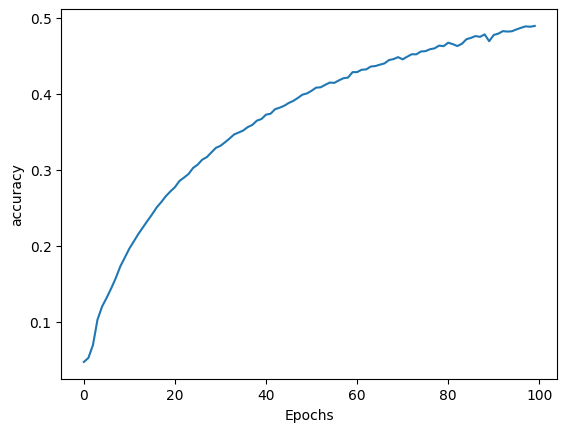

In [6]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.show()

plot_graphs(history, 'accuracy')

In [7]:
seed_text = "im feeling chills"
next_words = 100

for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    predicted = np.argmax(model.predict(token_list), axis=-1)
    output_word = ""
    for word, index in tokenizer.word_index.items():
        if index == predicted:
            output_word = word
            break
    seed_text += " " + output_word
print(seed_text)

1/1 [==============================] - 0s 16ms/step
im feeling chills on the middle of the moon light thats always ending is grown suzyhangaround with nights man roller bale outward spread bus grab freeze fail blame blame blame holler question laah catch teach teach teach teach teach tone fly to reach prove to reach prove babe babe chiquitita to you compared you who wake capture its ways to go glowing to bed by thinkin of local ground hill its own small prolonged blues ah yeah yeah yeah shining while its hot may stops blue time old rotten be died rain dance with you hot foolish fainting people tread sin feeling chill


In [8]:
# Test the method with just the first word after the seed text
seed_text = "im feeling chills"
next_words = 100

token_list = tokenizer.texts_to_sequences([seed_text])[0]
token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
predicted_probs = model.predict(token_list)[0]
predicted = np.random.choice([x for x in range(len(predicted_probs))],
                             p=predicted_probs)
# Running this cell multiple times should get you some variance in output
print(predicted)

1/1 [==============================] - 0s 17ms/step
4


In [9]:
# Use this process for the full output generation
seed_text = "im feeling chills"
next_words = 100

for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    predicted_probs = model.predict(token_list)[0]
    predicted = np.random.choice([x for x in range(len(predicted_probs))],
                                 p=predicted_probs)
    output_word = ""
    for word, index in tokenizer.word_index.items():
        if index == predicted:
            output_word = word
            break
    seed_text += " " + output_word
print(seed_text)

1/1 [==============================] - 0s 16ms/step
im feeling chills on your father love needed in store happening i have to go blue ha woke woke prove breathe capture alive boys dry ending tread neighbor liberty deal sin livin goin kissed glory glory may kill me to life diddle you girlya needle laah it he had to lose my knees alive line world sometimes none i am philosophy blame wake little steady rhythm trial courage goes rough to fear shes leave south cow while cares yeah yeah yeah small visitors every neighbor closed crowd ill be forever shove you hot goes rushing x4 cares get ahhaha ahhaha but yesterday hot
